# Fits over Directory
Run analysis procedures over directory to get fits and plots. Probably have to do manual labour but lets see...

In [1]:
#importing directories
from random import gauss
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import os
from astropy.io import ascii
import GetLightcurves as gc
from transit import occultnonlin, occultquad

Global Constants over entire code

In [2]:
rv_entry=ascii.read('../../Catalogs/robovetter_label.dat')
rv_pl=np.array(rv_entry['tce_plnt_num'])
rv_label = rv_entry['label']
rv_kepid=[('0000'+str(el)[:9])[-9:] for el in rv_entry['kepid']]
av_entry=ascii.read('../../Catalogs/autovetter_label.tab')
av_pl=np.array(av_entry['tce_plnt_num'])
av_label = av_entry['av_training_set']
av_kepid=[('0000'+str(el)[:9])[-9:] for el in av_entry['kepid']]
av_time=av_entry['tce_duration']
av_p=av_entry['tce_period']
av_timeerr=av_entry['tce_duration_err']

Fitting Functions: Gaussian, Lorentzian, Planet Transit

In [3]:
def gausses(x, A1, m1, s1, A2, m2, s2):
    y = A1*np.exp(-(x-m1)**2/(2*s1**2)) + A2*np.exp(-(x-m2)**2/(2*s2**2))
    return(y)

def lorz(x,A1,x0,g, A2, x02, g2):
    y = A1 / (1*((x-x0)**2+(g/2)**2)) + A2 / (1*((x-x02)**2+(g2/2)**2))
    return(y)

def new_plar(ph,p,minus, plus,rorb):
    u1 = (plus + minus)/2
    u2 = (plus - minus)/2
    znp = np.abs(rorb*np.sin(ph*np.pi))
    a= occultquad(znp,p,[u1,u2])  
    return(a -1) 

def new_plar_free(ph,p,u1,plus,rorb):
    u2 = plus - u1
    znp = np.abs(rorb*np.sin(ph*np.pi))
    a= occultquad(znp,p,[u1,u2])  
    return(a -1) 

def new_plar_free2(ph,p,u1,u2,rorb):
    znp = np.abs(rorb*np.sin(ph*np.pi))
    a= occultquad(znp,p,[u1,u2,])  
    return(a -1) 

def smooth(arr,k=10):
    kernel = np.ones(k)/k
    v=np.convolve(arr, kernel, mode='same')
    return(v)



### Fitting Model (Mandel and Algol 2002)

Run through directory to fit model to the lightcurves: The ones that dont fit properly are in the problist section, may have to approach them manually. 

In [96]:
#entries = os.listdir('../../processed_directories/go_circles/find_circles_rel/')
entries = np.loadtxt('../../processed_directories/go_circles/problem_nonfits', delimiter=' ', dtype='str')
print(len(entries))
#np.random.shuffle(entries)
problist=[]
for el in entries:
    
    df = pd.read_csv('../../processed_directories/go_circles/find_circles_rel/'+el+'.csv')
    flux = np.array([ x for x in df['flux_l'] if(not(np.isnan(x)))])
    fluxg = np.array([ x for x in df['flux_g'] if(not(np.isnan(x)))])
    phase = np.array(df['phase_l'])[:len(flux)]
    phaseg= np.array(df['phase_g'])[:len(fluxg)]
    #print(min(phaseg), max(phaseg))
   
    try: popt1,pcov1=curve_fit(new_plar_free2, phase, flux, bounds=([0.0001,-np.inf,-np.inf,1], [1,np.inf,np.inf,np.inf]))
    except: 
        print("no fit")
        problist.append(el[:11])
        continue
  
    
    print(el[:9],":",np.round(np.trace(pcov1),3),'ptd: ',np.round(popt1[0],5), 
        np.round((popt1[1]),3), np.round((popt1[2]),3), np.round(popt1[3],3))
     
    # if(popt1[1]>10 or popt1[2]>10):
    #     problist.append(el[:11])
    #     print('overboard')
    #     continue
    # if(popt1[3]<15.0001):
    #     problist.append(el[:11])
    #     print('under rad')
    #     continue
    # if(np.trace(pcov1)>1000):
    #     print("fit variance")
    #     problist.append(el[:11])
    #     continue
    dfg = pd.DataFrame(zip(phaseg,fluxg, new_plar_free2(np.array(phaseg), *popt1)),
        columns=['phase_g','flux_g','model_g'])
    dfl= pd.DataFrame(zip(phase, flux,new_plar_free2(np.array(phase), *popt1)),
        columns=[ 'phase_l', 'flux_l','model_l'])
    df1 = [dfl, dfg]
    df1 = pd.concat(df1, axis=1)

    store = pd.HDFStore('../../processed_directories/go_circles/temp/'+el[:11])
    store.put('data', df1)
    store.get_storer('data').attrs.metadata = {'attr':popt1, 
        'var':np.trace(pcov1)}
    store.close()

np.savetxt('../../processed_directories/go_circles/list_of_nonfits',problist,delimiter=' ',fmt="%s")

307
001025986 : 18868558.37 ptd:  0.13859 53.039 -556.139 218.2
001723078 : 1169116.189 ptd:  0.21136 55.601 -527.574 108.41
no fit
002299738 : 750358362.821 ptd:  0.1864 50.29 -2539.184 24.299
no fit
002299738 : 150562419.394 ptd:  0.2249 45.016 -218.895 41.008
no fit
no fit
003102384 : 625946.687 ptd:  0.18653 53.976 -501.075 13.971
003129238 : 8856123205.126 ptd:  0.12382 66.203 -381.997 114.74
003129238 : 20457109420.944 ptd:  0.2319 67.483 -358.212 3.579
003218908 : 100927.107 ptd:  0.2359 44.904 -325.039 11.894
003236705 : 3053582.01 ptd:  0.26415 43.922 -302.598 74.841
003239171 : 11144520.318 ptd:  0.18942 52.193 -465.153 16.495
no fit
003242039 : 23759312.896 ptd:  0.07962 32.219 -212.27 390.497
no fit
003338885 : 9530.312 ptd:  0.23196 43.884 -319.947 13.302
no fit
003348216 : 1686314.466 ptd:  0.21677 55.674 -482.735 20.68
003426367 : 3592706596.956 ptd:  0.23617 50.168 -399.136 132.087
003442055 : 20240.887 ptd:  0.2084 55.268 -493.948 12.537
003534076 : 7385685666911.768 p

[4094] 0.10981287885443204 24.269382146166258
-0.0239866264164447 0.0239902157336473
[ 0.42479079 -0.01083846  0.00089592  0.53452767  0.01002808  0.00092373] [ 0.14277209 -0.02158796  0.1         0.14277209  0.02159119  0.1       ]


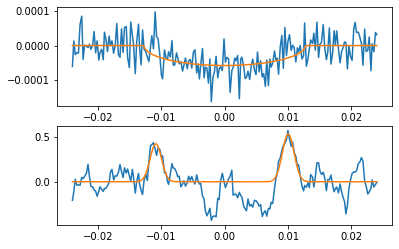

In [28]:
entries = os.listdir('../../processed_directories/go_circles/fit_circles_rel/')
el = entries[100]
store = pd.HDFStore('../../processed_directories/go_circles/fit_circles_rel/'+el)
df = store['data']
metadata = store.get_storer('data').attrs.metadata
store.close()

loc=np.where(np.asarray(rv_kepid)==el[:9])[0]
rv_loc_f = [x for x in loc if(str(rv_pl[x])==el[10:11])]
if(len(rv_loc_f)==0): 
    print("not in catalog")


print(rv_loc_f, av_time[rv_loc_f[0]]/(24*av_p[rv_loc_f[0]]), metadata['var'])
phase = np.array([ x for x in df['phase_l'] if(not(np.isnan(x)))])
flux = np.array([ x for x in df['flux_l'] if(not(np.isnan(x)))])
model = np.array([ x for x in df['model_l'] if(not(np.isnan(x)))])
res = np.convolve(df['flux_l']-df['model_l'], np.ones(10)/10, mode='same')
res = np.array([(el-np.median(res))/(max(res)-min(res)) for el in res])
popt1, pcov1 = curve_fit(gausses, phase, res, bounds=([max(res)/4,0.9*min(phase),0.0001,max(res)/4,0,0.0001], [max(res), 0, .1,max(res), 0.9*max(phase),.1]))
    
popt2, pcov2 = curve_fit(lorz, phase, res, bounds=([max(res)/4,0.9*min(phase),0.0001,max(res)/4,0,00.0001], [max(res), 0, .1,max(res), 0.9*max(phase), .1]))
print(min(phase),max(phase))
print(popt1, popt2)
fig, ax=plt.subplots(2,1)
ax[0].plot(df['phase_l'], df['flux_l'])
ax[0].plot(df['phase_l'], df['model_l'])
ax[1].plot(df['phase_l'], res )
ax[1].plot(phase,gausses(phase, *popt1))
#ax[1].plot(phase, lorz(phase, *popt2))
#ax[1].plot(phase, gausses(phase,0.3,-0.03,0.004,0.3,0.03,0.004))
#ax[0].set_xlim(-0.1,0.1)
#ax[1].set_xlim(-0.1,0.1)


### Finding Residuals
Fitting Gaussian/ Lorentzian Profiles to circles to see where we can get some recognisable peaks...

In [4]:
entries = os.listdir('../../processed_directories/go_circles/fit_circles_rel/')
problist=[]
for el in entries:
    store = pd.HDFStore('../../processed_directories/go_circles/fit_circles_rel/'+el)
    df = store['data']
    metadata = store.get_storer('data').attrs.metadata
    store.close()

    try: 
        loc=np.where(np.asarray(rv_kepid)==el[:9])[0]
        rv_loc_f = [x for x in loc if(str(rv_pl[x])==el[10:11])]
        #print(rv_loc_f, el)
    except: 
        print("not in catalog")
        continue

    if(len(rv_loc_f)==0): 
        print("not in catalog")
        continue
   
    k = np.ones(10)/10
    flux = np.convolve(np.array([ x for x in df['flux_l'] if(not(np.isnan(x)))]),k,mode='same')
    model = np.convolve(np.array([ x for x in df['model_l'] if(not(np.isnan(x)))]),k,mode='same')
    #flux = np.array(df['flux_l'])
    #model = np.array(df['model_l'])

    res = np.convolve(flux - model, k ,mode='same')
    phase = np.array(df['phase_l'])[:len(res)]
    try: popt1, pcov1 = curve_fit(gausses, phase, res, bounds=([max(res)/4,0.9*min(phase),0.0001,max(res)/4,0,0.0001], [max(res), 0, .1,max(res), 0.9*max(phase),.1]))
    except: 
        print("no gauss fit")
        continue
    
    print(el[:9],'ptd: ', np.abs(popt1[1]-popt1[4]))
     
    dfl = pd.DataFrame(zip(phase,flux,model,res, gausses(phase, *popt1)),
        columns=['phase_l', 'flux_l', 'model_l','residue', 'gaussian'])
    dfg = pd.DataFrame(zip(df['phase_g'],df['flux_g'],df['model_g']),
        columns=['phase_g','flux_g','model_g'])
    df1 = [dfl, dfg]
    df1 = pd.concat(df1, axis=1)
    store = pd.HDFStore('../../processed_directories/go_circles/fit_circles_with_res/'+el[:11])
    store.put('data', df1)
    store.get_storer('data').attrs.metadata = {'label':rv_label[rv_loc_f[0]],'gauss':popt1,'model':metadata['attr'],
        'mod_var':metadata['var'],'gdur':np.abs(popt1[1]-popt1[4]) ,'g_cov':np.trace(pcov1)}
    store.close()


np.savetxt('../../processed_directories/go_circles/list_of_nonfits_residue',problist,delimiter=' ',fmt="%s")

001432789 ptd:  0.039160015138841535
001432789 ptd:  0.06456902891939215
not in catalog
001718958 ptd:  0.0694090223747067
001721157 ptd:  0.03154737758910253
001724719 ptd:  0.03919199781637095
001724719 ptd:  0.021728502149280057
001725016 ptd:  0.019640151281155312
001865042 ptd:  0.03209011307148063
001871056 ptd:  0.022074523682486732
001871056 ptd:  0.010111486375067286
001995519 ptd:  0.008716520323851512
001996180 ptd:  0.06451026537657994
001996180 ptd:  0.03575211955249745
002019477 ptd:  0.03515839873908011
002019477 ptd:  0.03629915575695772
002142522 ptd:  0.020581191178762608
002161536 ptd:  0.010792455575288672
002161949 ptd:  0.024677676630598853
002165002 ptd:  0.019596514105796402
002299738 ptd:  0.25965343384519235
002301068 ptd:  0.023245475974778447
002302548 ptd:  0.018870348508024395
002305866 ptd:  0.027779974827328913
002305866 ptd:  0.01076490076235444
002307415 ptd:  0.02591625200584527
002307415 ptd:  0.019763043833292734
002422820 ptd:  0.023612694028103114

### Cumulative Batch Plotting

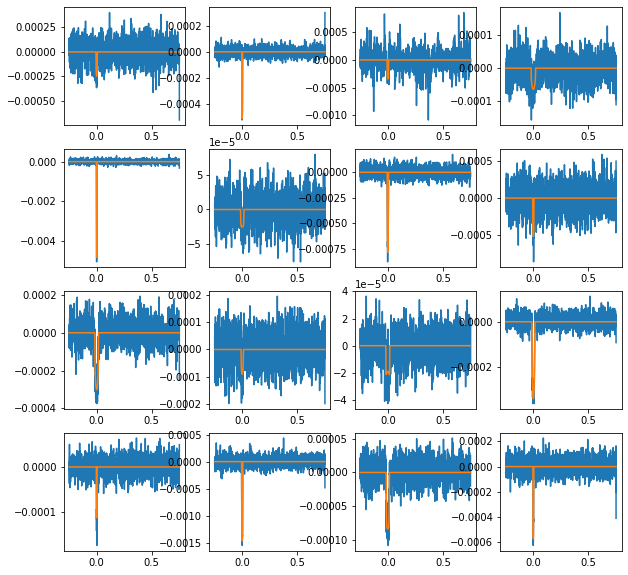

In [6]:
entries = os.listdir('../../processed_directories/go_circles/fit_circles_with_res/')
#np.loadtxt('../../processed_directories/go_circles/hot_jupiters')
np.random.shuffle(entries)
fig, axs = plt.subplots(4,4,figsize=(10,10))


for el,ax in zip(entries[:16],axs.ravel()):
    store = pd.HDFStore('../../processed_directories/go_circles/fit_circles_with_res/'+el)
    df = store['data']
    metadata = store.get_storer('data').attrs.metadata
    #df = pd.read_csv('../../processed_directories/go_circles/find_circles_rel/'+el)
    ax.plot(df['phase_g'],df['flux_g'])
    ax.plot(df['phase_g'],df['model_g'])
    #ax.legend()
    #print(metadata['gauss'], metadata['lorz'])
    #ax.plot(df['phase_l'],df['residue'])
    #ax.plot(df['phase_l'],df['gaussian'])
    #ax.plot(df['phase_l'],df['lorentzian'])
    #ax.set_xlim(-0.2,0.2)
    store.close()

### Selection of promising results

Filter out the ones where the gaussian peaks can actually correspond to the residual features we're looking for

In [7]:
entries = os.listdir('../../processed_directories/go_circles/fit_circles_with_res/')
for el in entries:
    store = pd.HDFStore('../../processed_directories/go_circles/fit_circles_with_res/'+el)
    df = store['data']
    try: metadata = store.get_storer('data').attrs.metadata
    except: 
        store.close()
        continue
    
    dur1 = metadata['gdur']
    arr1 = metadata['gauss']
    phase = np.array([ x for x in df['phase_l'] if(not(np.isnan(x)))])
    dur = max(phase)-min(phase)
    if((dur1 < dur/2) and arr1[1]>-1.1*dur/4 and arr1[4]<1.1*dur/4): 
            store2 = pd.HDFStore('../../processed_directories/go_circles/analyse_circles_rel/'+el[:11])
        
            data = store['data']
            print(dur/2,dur1,arr1[1], arr1[4])

            store2.put('data', data)
            store2.get_storer('data').attrs.metadata = metadata
            store2.close()
        
    store.close()

0.0287958355620503 0.02591625200584527 -0.012953162658959594 0.012963089346885675
0.037070220336318 0.0333631983026862 -0.01667785160243511 0.01668534670025109
0.00963094783946865 0.008739562952866212 -0.0036023937162565707 0.005137169236609642
0.02654185146093365 0.023887666314840288 -0.01192779270932076 0.011959873605519526
0.05318580195307725 0.04786722175776953 -0.023918427899479844 0.023948793858289682
0.08841101452708239 0.07956991307437417 -0.039787405729293825 0.039782507345080334
0.01728310063481325 0.015554790571331925 -0.007775165699422335 0.00777962487190959
0.0347375236451625 0.03126377128064625 -0.015644213743507832 0.015619557537138421
0.0782484598457813 0.07042361386120316 -0.03521812520921229 0.03520548865199088
0.025223194621503298 0.02270087515935297 -0.011353913974016864 0.011346961185336105
0.2154977023601532 0.19394793212413788 -0.09696557745337486 0.09698235467076302
0.040994221344590145 0.036894799210131134 -0.018476510792970646 0.018418288417160488
0.2429422810

### Final Plotting
Plot out the results and manually filter the plots.

KeyboardInterrupt: 

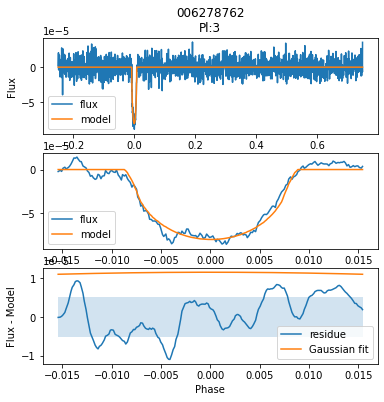

In [10]:
entries = os.listdir('../../processed_directories/go_circles/analyse_circles_rel/')
#np.random.shuffle(entries)

for el in entries[:60]:
    fig, ax = plt.subplots(3,1,figsize=(6,6))
    store = pd.HDFStore('../../processed_directories/go_circles/analyse_circles_rel/'+el)
    df = store['data']
    
    phase=df['phase_l']
    mn = np.mean(df['residue']**2)
    #k = np.ones(2)/2
    ax[0].plot(df['phase_g'],df['flux_g'], label='flux')
    ax[0].plot(df['phase_g'],df['model_g'], label='model')
    ax[1].plot(phase,df['flux_l'], label='flux')
    ax[1].plot(phase,df['model_l'], label='model')
    ax[2].plot(phase,df['residue'], label='residue')
    ax[2].plot(phase,df['gaussian'], label='Gaussian fit')
    ax[0].set_ylabel('Flux')
    ax[2].set_xlabel('Phase')
    ax[2].set_ylabel('Flux - Model')
    ax[2].fill_between(phase, np.sqrt(mn)*np.ones(len(phase)), -np.sqrt(mn)*np.ones(len(phase)), alpha=0.2)
    ax[1].legend()
    ax[0].legend()
    ax[2].legend()
    ax[0].set_title(el[:9]+'\nPl:'+el[10:])
    plt.savefig('../../processed_directories/go_circles/'+el+'.jpg')
    plt.close()
    store.close()

### Plotting for good fits
Make plots for good fits!!!


In [99]:
entries = os.listdir('../../processed_directories/go_circles/temp/')
#np.random.shuffle(entries)
global i
problist=[]
i=0
for el in entries:
    fig, ax = plt.subplots(3,1,figsize=(8,8))
    store = pd.HDFStore('../../processed_directories/go_circles/temp/'+el)
    df = store['data']
    metadata = store.get_storer('data').attrs.metadata
    attr = metadata['attr']
    if(metadata['var']<1000): 
        i+=1
        print(metadata['var'],attr[1], attr[2])

    # else: 
    #     plt.close()
    #     continue
    phase=df['phase_l']

    # if(attr[1]<-0.99999 or attr[1]>0.99999 or attr[2]<0.0000001 or attr[2]>0.99999):
    #     print('skip')
    #     #plt.close()
    #     #continue
    # else: continue


    problist.append(el)
    props = dict(boxstyle='round', facecolor='black', alpha=0.8, pad=1)
    txt = "$R_{pl}$/$R_{st}$:"+str(np.round(attr[0],4))+"\nu1:"+str(np.round((attr[2]+attr[1])/2,4
        ))+"\nu2:"+str(np.round((attr[2]-attr[1])/2,4))+"\n$R_{orb}/R_{st}$:"+str(np.round(attr[3],4))
    
    txt = "$R_{pl}$/$R_{st}$:"+str(np.round(attr[0],4))+"\nu1:"+str(np.round(attr[1],4
        ))+"\nu2:"+str(np.round(attr[2],4))+"\n$R_{orb}/R_{st}$:"+str(np.round(attr[3],4))


    ax[0].text(0.80, 0.5, txt, fontsize=11,transform=ax[0].transAxes,  horizontalalignment='center',
            verticalalignment='center', linespacing=2, bbox=props, color='white')
    
    mn=  np.mean(np.array([x for x in (df['flux_l']-df['model_l'])**2 if not np.isnan(x)]))
    #k = np.ones(2)/2
    ax[0].plot(df['phase_g'],df['flux_g'], label='flux',color='#b19cd9')
    #ax[0].plot(df['phase_g'],df['model_g'], label='model', color='#311432')
    ax[1].plot(phase,df['flux_l'], label='flux', color='#7a4988', marker='.', ls='None')
    ax[1].plot(phase,df['model_l'], label='model',color='#311432')
    ax[2].plot(phase,df['flux_l']-df['model_l'], label='var:'+str(np.round(metadata['var'],5)), color='#7a4988', marker='.')
    #ax[2].plot(phase,df['gaussian'], label='Gaussian fit')
    ax[0].set_ylabel('Flux')
    ax[2].set_xlabel('Phase')
    ax[2].set_ylabel('Flux - Model')
    ax[2].fill_between(phase, np.sqrt(mn)*np.ones(len(phase)), -np.sqrt(mn)*np.ones(len(phase)), alpha=0.6, 
        color='#b19cd9',label='1$\sigma$')
    ax[1].legend()
    ax[0].legend()
    ax[2].legend()
    ax[0].set_title(el[:9]+'\nPl:'+el[10:])
    plt.savefig('../../processed_directories/go_circles/'+el+'.jpg')
    plt.close()
    store.close()

#np.savetxt('../../processed_directories/go_circles/hot_jupiters',problist,delimiter=' ',fmt="%s")

20.390218183509134 0.8710426606129442 -0.8102958073343549
13.886472104345989 0.4188713349288536 0.8029033726252136
6.3061342663660716 0.7119714550563011 -0.6062260133293765
5.573177774062482 -0.4810525186436465 1.6797200036984583
4.10769133866693 3.148964760818495 -4.1134790966513
2.6723014306498794 0.9302120809894315 -0.05933567819688893
100.05333118170921 0.6266883536283155 -1.0464223977321137
10.3144669402506 -1.6342410245469092 2.033995780417337
2.8347144729235563 2.348424116829937 -2.7636927952166563
3.5225164625133663 2.537350691118388 -3.069532938498947
53.33229738768644 -0.2524925320515648 0.5243826499264059
34.363065536081436 1.303879986173428 -0.7385790003922095
78.7878809044651 -0.7689129740189473 0.6229295951771665
65.20891518517728 0.563240711653983 -5.224328367321268
13.773666396389292 1.0929026894300975 -0.17624887440060327
35.06199191850771 1.0011913290007157 -1.8056290990814539
8.007055099248907 -2.83724682806234 3.561481804103654
56.115614213566225 -0.0693673720413379

### Manual Fitting

Here we write a quick handy few lines of code to do stuff manually... to check, and to finish fitting the rest.

c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


0.0016700220389252384
['0.02872', '0.80636', '1.00000', '70.98020']


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%
c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


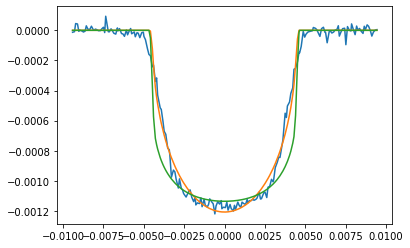

In [43]:
PATH = '../../processed_directories/go_circles/find_circles_rel/'
el = '004349452_1.csv'

df = pd.read_csv(PATH+el)

flux = np.array([ x for x in df['flux_l'] if(not(np.isnan(x)))])
phase = np.array([ x for x in df['phase_l'] if(not(np.isnan(x)))])

#some brute force shit
# uarr=np.linspace(0.1,2, 10)
# varr=np.linspace(0.1,0.9, 10)
# minpopt=[]
# mincov = 1000
# for u in uarr:
#     popt1,pcov1=curve_fit(new_plar_free2, phase, flux, bounds=([0,u-0.01*u,-0.1,10], [1,u+0.01*u,0.9,200]))
#     rchi = np.sum((flux/np.abs(min(flux)) - new_plar_free2(phase, *popt1)/np.abs(min(flux)))**2) / len(flux)
#     print(rchi)
#     if(rchi<mincov):
#         mincov = rchi
#         minpopt = popt1
minpopt,mincov=curve_fit(new_plar, phase, flux, bounds=([0,-0.1,0,10], [1,1,1,200]))


rchi = np.sum((flux/np.abs(min(flux)) - new_plar(phase, *minpopt)/np.abs(min(flux)))**2) / len(flux)
print(rchi)

plt.plot(phase, flux)
#print("fin:",np.trace(mincov))
plt.plot(phase, new_plar(phase, *minpopt))
plt.plot(phase, new_plar(phase, 0.031, 0.02,0.61, 70.9))
print(["{:.5f}".format(x) for x in minpopt])
plt.show()

Quick check on theoretical transit sims


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%
c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%
c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%
c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%
c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


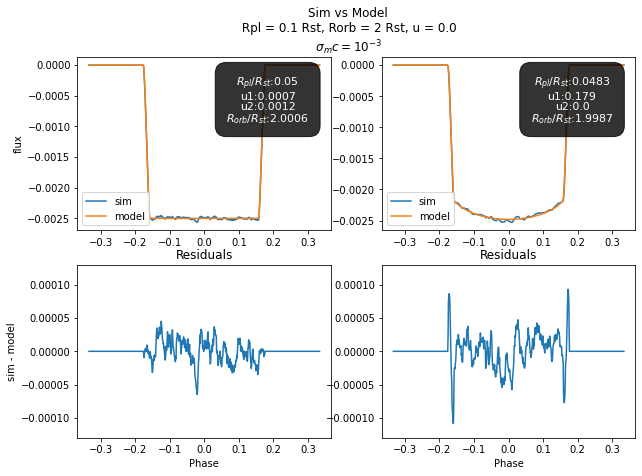

In [35]:
df = pd.read_csv('2d3d_0.05R_circ.csv', delimiter=',')
np.random.seed(10000)
#noise = np.random.normal(1,0.002777,len(df))
noise = np.ones(len(df))

d2=df['2d']-1
d3=df['3d']-1
ph = np.linspace(-1/3, 1/3, len(df))
d2n = np.convolve((df['2d']*noise-1),np.ones(5)/5, mode='same')
d3n = (df['3d']*noise-1)
#std2 = df['2dstd']
#std3 = df['3dstd']
#print(np.mean(np.array([d2/el for el in std2 if(el>0)])))
#print(np.mean(np.array([d3/el for el in std3 if(el>0)])))
#print(np.mean(std2), np.mean(std3))

par2d, cov2d=curve_fit(new_plar_free2, ph, d2, bounds=([0,0,0,1], [0.5,1,1,7]))
par3d, cov3d=curve_fit(new_plar_free2, ph, d3, bounds=([0,0,0,1], [0.5,1,1,7]))
#print(["{:.5f}".format(x) for x in minpopt])

fig, ax = plt.subplots(2,2, figsize=(10,7))
plt.suptitle('Sim vs Model\n Rpl = 0.1 Rst, Rorb = 2 Rst, u = 0.0\n $\sigma_mc = 10^{-3}$')

props = dict(boxstyle='round', facecolor='black', alpha=0.8, pad=1)
txt = "$R_{pl}$/$R_{st}$:"+str(np.round(par2d[0],4))+"\nu1:"+str(np.round(par2d[1],4
        ))+"\nu2:"+str(np.round(par2d[2],4))+"\n$R_{orb}/R_{st}$:"+str(np.round(par2d[3],4))

props2 = dict(boxstyle='round', facecolor='black', alpha=0.8, pad=1)
txt2 = "$R_{pl}$/$R_{st}$:"+str(np.round(par3d[0],4))+"\nu1:"+str(np.round(par3d[1],4
        ))+"\nu2:"+str(np.round(par3d[2],4))+"\n$R_{orb}/R_{st}$:"+str(np.round(par3d[3],4))


ax[0][1].text(0.75, 0.75, txt, fontsize=11,transform=ax[0][1].transAxes,  horizontalalignment='center',
            verticalalignment='center', linespacing=1, bbox=props, color='white')

ax[0][0].text(0.75, 0.75, txt2, fontsize=11,transform=ax[0][0].transAxes,  horizontalalignment='center',
            verticalalignment='center', linespacing=1, bbox=props2, color='white')    

ax[0][0].plot(ph, d3n, label='sim', zorder=1)
ax[0][1].plot(ph, d2n, label='sim', zorder=1)
#ax[0][0].errorbar(ph, d3, std3,None, label='sim', zorder=2)
#ax[0][1].errorbar(ph, d2, std2,None, label='sim', zorder=2)

ax[0][0].plot(ph, new_plar_free2(ph, *par3d), label='model')
ax[0][1].plot(ph, new_plar_free2(ph, *par2d), label='model')
# ax[0][0].plot(ph, new_plar_free2(ph, 0.01, 0.45, 0.0, 2), label='model')
# ax[0][1].plot(ph, new_plar_free2(ph, 0.01, 0.45, 0.0, 2), label='model')
ax[0][0].legend(loc='lower left')
ax[1][1].set_xlabel('Phase')
ax[1][0].set_xlabel('Phase')
ax[1][0].set_ylabel('sim - model')
ax[0][0].set_ylabel('flux')
ax[0][1].legend(loc='lower left')
ax[1][0].set_title('Residuals')
ax[1][1].set_title('Residuals')
ax[1][0].plot(ph, d3-new_plar_free2(ph, *par3d))
ax[1][1].plot(ph, d2-new_plar_free2(ph, *par2d))
ax[1][1].set_ylim(-0.00013,0.00013)
ax[1][0].set_ylim(-0.00013,0.00013)
#plt.savefig('th_sim_fit_0.1R_n2.jpg')

dfop = pd.DataFrame(zip(ph,d3n,d2n,new_plar_free2(ph, *par3d),new_plar_free2(ph, *par2d)), columns=['phase', 'flux','flux2d', 'model','model2d'])
dfop.to_csv('fprez_simp.csv', sep=',',index=False)
plt.savefig('fprez_fit.jpg')



Signal to Noise Ratio Analysis

c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


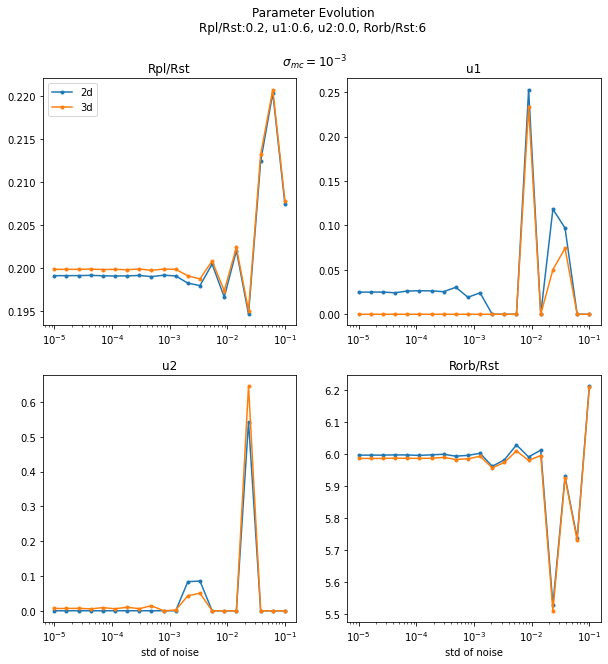

In [11]:
#d2 d3 std2 std3
df = np.loadtxt('2d3d_0.2R_circ.csv', delimiter=',')
np.random.seed(10000)

std_n = np.logspace(-1, -5, 20)
d2=df[:,1]-1
d3=df[:,3]-1
ph = df[:,0]*0.5/ np.pi
d2n = (df[:,1]*noise-1)
d3n = (df[:,3]*noise-1)
std2 = df[:,2]
std3 = df[:,4]

parrarr2d=[]
parrarr3d=[]
snrarr2=[]
snrarr3=[]
for el in std_n:
    noise = np.random.normal(1,el,len(df))
    d2n = (df[:,1]*noise-1)
    d3n = (df[:,3]*noise-1)
    #snr2 = np.mean(d2/(d2-d2n)**2)
    #snr3 = np.mean(d3/(d3-d3n)**2)
    #snrarr2.append(snr2)
    #snrarr3.append(snr3)
    par2d, cov2d=curve_fit(new_plar_free2, ph, d2n, bounds=([0,0,0,1], [1,1,1,10]))
    par3d, cov3d=curve_fit(new_plar_free2, ph, d3n, bounds=([0,0,0,1], [1,1,1,10]))
    parrarr2d.append(par2d)
    parrarr3d.append(par3d)

parrarr2d = np.asarray(parrarr2d)
parrarr3d = np.asarray(parrarr3d)
fig, ax = plt.subplots(2,2,figsize=(10,10))
plt.suptitle('Parameter Evolution\nRpl/Rst:0.2, u1:0.6, u2:0.0, Rorb/Rst:6\n \n $\sigma_{mc} = 10^{-3}$')
ax[0][0].plot(std_n,parrarr2d[:,0], marker='.', label='2d')
ax[0][0].plot(std_n,parrarr3d[:,0], marker='.', label='3d')
ax[0][0].set_title('Rpl/Rst')
ax[0][0].set_xscale('log')
ax[0][0].legend()
ax[0][1].plot(std_n,parrarr2d[:,1], marker='.')
ax[0][1].plot(std_n,parrarr3d[:,1], marker='.')
ax[0][1].set_title('u1')
ax[0][1].set_xscale('log')
ax[1][0].plot(std_n,parrarr2d[:,2], marker='.')
ax[1][0].plot(std_n,parrarr3d[:,2], marker='.')
ax[1][0].set_title('u2')
ax[1][0].set_xscale('log')
ax[1][0].set_xlabel('std of noise')
ax[1][1].plot(std_n,parrarr2d[:,3], marker='.')
ax[1][1].plot(std_n,parrarr3d[:,3], marker='.')
ax[1][1].set_title('Rorb/Rst')
ax[1][1].set_xscale('log')
ax[1][1].set_xlabel('std of noise')
plt.savefig('snr_calc.jpg')
plt.show()



Some labour work...

In [8]:
fins = os.listdir('../../processed_directories/go_circles/plots_rel/')
takeout1 = os.listdir('../../processed_directories/go_circles/fit_circles_rel/')
takeout2 = os.listdir('../../processed_directories/go_circles/temp/')

for el in fins:
    loc = np.where(np.asarray(takeout2)==el[:11])[0]
    #print(loc)

    if(len(loc)>0):
        store1 = pd.HDFStore('../../processed_directories/go_circles/temp/'+el[:11])
        try: df1 = store1['data']
        except: continue
        metadata = store1.get_storer('data').attrs.metadata
        metadata['method']='ind'
        print(metadata)

        store2 = pd.HDFStore('../../processed_directories/go_circles/final_fits/'+el[:11])
        
        data = store1['data']

        store2.put('data', data)
        store2.get_storer('data').attrs.metadata = metadata
        store2.close()
        store1.close()
    
    

{'attr': array([ 4.48705411e-02,  3.41655220e+00, -2.83432109e+00,  2.23965929e+02]), 'var': 690.8547192282656, 'method': 'ind'}
{'attr': array([1.06379397e-02, 7.09876862e-01, 1.35042185e+00, 2.03375197e+02]), 'var': 27.30844228960403, 'method': 'ind'}
{'attr': array([ 2.10527609e-02, -6.62186705e-02,  1.38530963e+00,  1.91085823e+02]), 'var': 567.3769385901734, 'method': 'ind'}
{'attr': array([ 1.75241745e-02,  4.96040411e-01, -1.36517388e+00,  2.12541651e+02]), 'var': 10.90258820392787, 'method': 'ind'}
{'attr': array([ 1.31833104e-02,  3.90943763e+00, -3.90730696e+00,  1.93298477e+02]), 'var': 12.647177287396964, 'method': 'ind'}
{'attr': array([ 2.57763987e-02,  1.92095363e+00, -3.06412059e+00,  1.89428994e+02]), 'var': 15.68053085429298, 'method': 'ind'}
{'attr': array([ 1.90220721e-02,  1.96905493e-01, -6.89636455e-01,  2.11070149e+02]), 'var': 67.25921403481495, 'method': 'ind'}
{'attr': array([ 1.39171762e-02,  2.35578580e+00, -1.97717775e+00,  2.09895642e+02]), 'var': 4.66999

In [9]:
takeout = os.listdir('../../processed_directories/go_circles/find_circles_rel/')
takin = os.listdir('../../processed_directories/go_circles/final_fits/')
problist=[]

for el in takeout:
    if(np.any(np.array(takin)==el[:11])):
        continue
    else: problist.append(el[:11])

np.savetxt('../../processed_directories/go_circles/problem_nonfits',problist,delimiter=' ',fmt="%s")
    


### Optimal Kepler Parameters
Plotting histograms of optimal kepler parameters to see what values we should take to construct our ideal simulation

C:\Users\Hp\AppData\Local\Temp/ipykernel_10520/2248811819.py:4: UserWarning: Warning: converting a masked element to nan.
  rorb = np.array([ x for x in df['koi_dor'] if not np.isnan(x)])
C:\Users\Hp\AppData\Local\Temp/ipykernel_10520/2248811819.py:5: UserWarning: Warning: converting a masked element to nan.
  rpl = np.array([ x for x in df['koi_ror'] if not np.isnan(x)])


[24.81  77.9   53.5   ...  4.331  6.04  12.06 ]
0.016150895 2.24189525


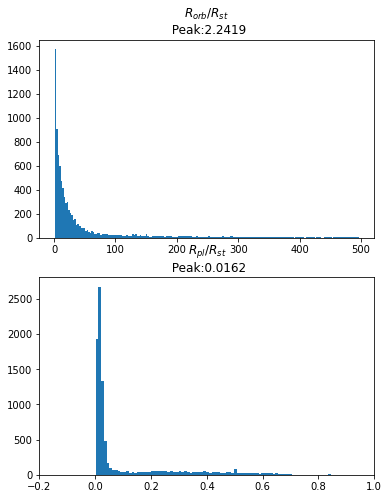

In [4]:
from astropy.io import ascii
df = ascii.read('../../Catalogs/ex_TCE_extra.tab')
# print(df['koi_ldm_coeff1'], df['koi_ldm_coeff2'], df['koi_dor'], df['koi_ror'])
rorb = np.array([ x for x in df['koi_dor'] if not np.isnan(x)])
rpl = np.array([ x for x in df['koi_ror'] if not np.isnan(x)])
#print(np.sum(rorb>1000))
rpl = np.array([x for x in rpl if x<1])
rorb = np.array([x for x in rorb if x>1 and x<500])
print(rorb)

fig, ax = plt.subplots(2,1,figsize=(6,8))
yo, xo, _ = ax[0].hist(rorb, bins=200)
yp, xp, _ = ax[1].hist(rpl, bins=100)

vp=(xp[np.where(yp == yp.max())[0]]+xp[np.where(yp == yp.max())[0]+1])[0]/2
vo=(xo[np.where(yo == yo.max())[0]]+xo[np.where(yo == yo.max())[0]+1])[0]/2

print(vp,vo)

ax[1].set_title('$R_{pl}/R_{st}$\n Peak:'+str(np.round(vp,4)))
ax[0].set_title('$R_{orb}/R_{st}$\n Peak:'+str(np.round(vo,4)))
ax[1].set_xlim(-0.2,1)

plt.savefig('parameter_histogram2.jpg')


C:\Users\Hp\AppData\Local\Temp/ipykernel_1196/352048212.py:1: UserWarning: Warning: converting a masked element to nan.
  us = np.array([[x,y] for x,y in zip(df['koi_ldm_coeff1'], df['koi_ldm_coeff2'])])


0
(array([8], dtype=int64), array([20], dtype=int64))
1572.0 [array([0.34492]), array([0.28126667])] [array([0.37236]), array([0.30136])]


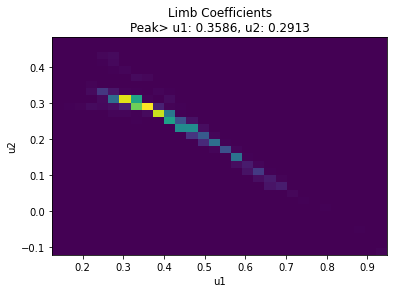

In [93]:
us = np.array([[x,y] for x,y in zip(df['koi_ldm_coeff1'], df['koi_ldm_coeff2'])])
us=np.array([el for el in us if not np.any(np.isnan(el))])
print(np.sum(np.isnan(us)))
z,x,y,_ = plt.hist2d(us[:,0], us[:,1], bins=(30,30))
#print(el)
#print(z)
wh = np.where(z==max(z.reshape(-1)))
print(wh)
print(max(yo),[x[wh[0]],y[wh[1]]], [x[wh[0]+1], y[wh[1]+1]])
v1 = (x[wh[0]][0]+x[wh[0]+1][0])/2
v2 = (y[wh[1]][0]+y[wh[1]+1][0])/2
plt.xlabel('u1')
plt.title('Limb Coefficients\nPeak> u1: '+str(np.round(v1,4))+', u2: '+str(np.round(v2,4)))
plt.ylabel('u2')

plt.savefig('parameter_histogram.jpg')
plt.show()

C:\Users\Hp\AppData\Local\Temp/ipykernel_10520/3339595693.py:1: UserWarning: Warning: converting a masked element to nan.
  snr = np.array([ x for x in df['koi_model_snr'] if not np.isnan(x)])


9564
67


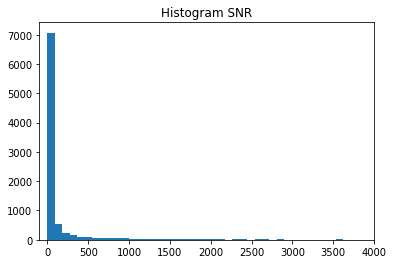

In [14]:
snr = np.array([ x for x in df['koi_model_snr'] if not np.isnan(x)])
print(len(snr))
print(np.sum(snr>5000))
y,x, _ = plt.hist(snr, bins=100)
#print(x,y)
plt.xlim(-100,4000)
plt.title('Histogram SNR')
plt.savefig('snr_hist.jpg')
plt.show()